<a href="https://colab.research.google.com/github/emmaewade/ML-Project/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import random
import collections
import timeit
import xgboost as xgb
import sklearn.metrics

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
!ls



final_test_df.csv   public_image_df.csv  sample_data	     train_meta_df.csv
final_train_df.csv  public_meta_df.csv	 train_desc_df.csv   train_title_df.csv
public_desc_df.csv  public_title_df.csv  train_image_df.csv


In [ ]:
# Load training datasets
desc_train = pd.read_csv('train_desc_df.csv')
meta_train = pd.read_csv('train_meta_df.csv')
image_train = pd.read_csv('train_image_df.csv')
title_train = pd.read_csv('train_title_df.csv')

# Load public datasets (datasets used for the rankings)
desc_test = pd.read_csv('public_desc_df.csv')
meta_test = pd.read_csv('public_meta_df.csv')
image_test = pd.read_csv('public_image_df.csv')
title_test = pd.read_csv('public_title_df.csv')


print('Dimension of train description data is', desc_train.shape)
print('Dimension of train meta data is', meta_train.shape)
print('Dimension of train image data is', image_train.shape)
print('Dimension of train title data is', title_train.shape)

print('Dimension of test description data is', desc_test.shape)
print('Dimension of test meta data is', meta_test.shape)
print('Dimension of test image data is', meta_test.shape)
print('Dimension of test title data is', title_test.shape)

Dimension of train description data is (3000, 51)
Dimension of train meta data is (3000, 14)
Dimension of train image data is (3000, 4001)
Dimension of train title data is (3000, 51)
Dimension of test description data is (986, 51)
Dimension of test meta data is (986, 13)
Dimension of test image data is (986, 13)
Dimension of test title data is (986, 51)


In [ ]:
meta_train.head()

,comp_id,ad_blocked,embed,ratio,duration,language,partner,partner_active,n_likes,views,n_tags,n_formats,dayofweek,hour
0,1,False,True,1.77778,86,3,True,False,0,290,3,0,5,6
1,2,False,True,1.33333,1129,2,True,False,0,1443,0,2,5,6
2,3,False,True,1.76667,1163,2,True,False,0,329,0,1,5,6
3,4,False,True,1.77778,1326,2,True,False,0,63,0,3,5,6
4,5,False,True,1.77273,2612,2,True,False,3,37,0,0,5,6


In [ ]:
image_train.head()

,comp_id,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,...,image_3991,image_3992,image_3993,image_3994,image_3995,image_3996,image_3997,image_3998,image_3999,image_4000
0,1,0.484456,0.036087,-0.149328,0.144475,-0.617386,0.035018,0.169174,-0.005733,-0.104908,...,-0.090408,-0.032915,-0.010857,-0.015954,0.123416,0.195833,-0.066449,0.115818,-0.005140,0.017278
1,2,0.074533,-0.015655,-0.016286,-0.480964,0.687917,0.037131,-0.149725,-0.002098,0.099383,...,-0.625816,-0.009616,0.004558,0.008310,-0.173496,0.133518,-0.488898,0.084832,0.146566,0.007997
2,3,-0.396809,0.021490,-1.723037,0.666147,-0.631924,0.047724,0.336041,-0.003904,0.039683,...,-0.078059,0.086320,-0.005606,0.002414,-0.164493,0.218473,0.151292,-0.076860,0.008321,0.012555
3,4,0.995316,0.012766,0.387472,-0.684791,-0.209261,0.013654,0.138517,0.005586,0.079277,...,-0.190714,-0.005452,-0.003889,0.013430,0.344406,0.038220,0.210446,-0.145128,-0.019172,0.000532
4,5,-0.611648,0.000860,-0.572393,0.894287,-0.191228,-0.111583,-0.011111,0.003231,-0.160582,...,-0.040437,-0.142134,-0.022771,-0.013134,-0.024869,0.125129,0.215967,0.005288,0.145715,0.001425


In [ ]:
desc_train.head()

,comp_id,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9,...,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49,desc_50
0,1,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,...,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
1,2,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,...,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
2,3,-0.356706,0.213562,0.252663,0.090735,0.328961,-0.482705,0.067300,0.384217,-0.147253,...,-0.626436,-0.102908,0.576792,-0.805986,0.310637,0.422263,0.403496,0.264240,7.057590,-0.252417
3,4,-0.294013,0.165262,0.257102,0.421037,0.463214,-0.769155,0.159450,0.236385,-0.183974,...,-0.435836,0.052975,0.108777,-0.599593,0.408430,0.591615,0.415667,0.334706,7.025648,-0.309093
4,5,-0.028657,0.157017,0.282709,-2.674227,-0.711383,2.259387,-0.162175,0.605468,0.712229,...,-1.714496,0.297421,-0.097744,0.000669,-1.639307,0.244313,0.099975,0.371806,-2.259024,-0.131085


In [ ]:
title_train.head()

,comp_id,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_41,title_42,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50
0,1,-0.977637,-0.543310,0.079403,0.205560,-1.497104,0.230466,0.566112,-0.662264,0.130342,...,0.059434,-0.272340,-0.030180,-0.109040,-0.033425,0.728739,0.142030,0.397541,1.270722,-0.816523
1,2,0.041873,0.644655,0.140869,-0.664714,-0.062992,0.240086,-1.017593,1.019706,0.340133,...,0.242961,-0.404538,0.335224,-0.158068,-0.178225,0.351125,0.959121,0.673848,-0.530106,0.133466
2,3,-0.905595,0.097928,0.111981,-0.064753,-1.566516,0.140807,-0.946588,-0.342442,0.031226,...,0.414191,-0.457968,0.157185,-0.116985,0.404937,-0.220503,0.443171,0.643445,0.357957,0.525154
3,4,0.069220,0.411544,0.177700,-0.739998,-0.932620,-0.717982,-0.406487,-0.267096,0.114066,...,0.211731,-0.812590,0.258014,-0.180143,-0.564691,-0.515378,0.613686,0.817547,0.325042,0.254415
4,5,0.503560,-0.210970,-0.085412,0.549240,-0.019521,-0.255597,0.841144,0.250485,0.224235,...,-0.517912,0.543584,0.492052,-0.204867,-0.011538,-0.328607,-0.150055,-0.992373,-0.266003,-0.037134


check for missing values

In [ ]:
meta_train.isnull().sum()

comp_id           0
ad_blocked        0
embed             0
ratio             0
duration          0
language          0
partner           0
partner_active    0
n_likes           0
views             0
n_tags            0
n_formats         0
dayofweek         0
hour              0
dtype: int64

 Let’s look at the distribution of our hour column, which represents when the video was uploaded to the hosting platform.

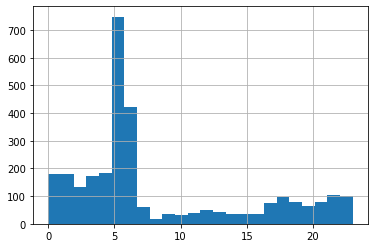

In [ ]:
meta_train['hour'].hist(bins=24)

Next, let’s look at the dayoftheweek distribution, which will tell us which day of the week the video was uploaded.

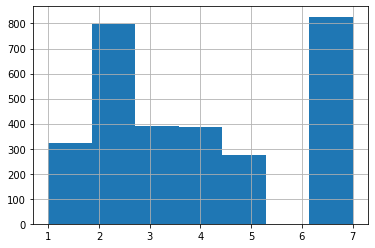

In [ ]:
meta_train['dayofweek'].hist(bins=7)


we’ll look at the distribution of our views column.

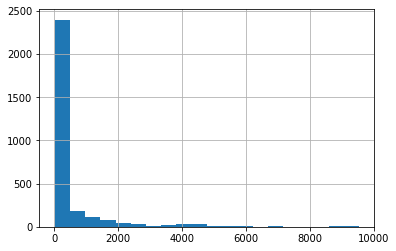

In [ ]:
meta_train['views'].hist(bins=20)

Because we have outliers at the upper end of this view data, this plot isn’t very useful. The solution here is to apply a log transformation to our data, like so:

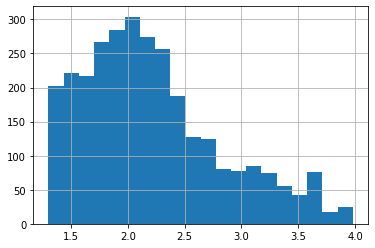

In [ ]:
np.log10(meta_train['views']).hist(bins=20)

Now we’ll look at the distribution of our duration column.

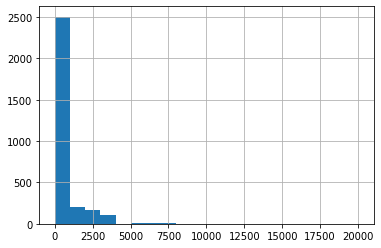

In [ ]:
meta_train['duration'].hist(bins=20)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


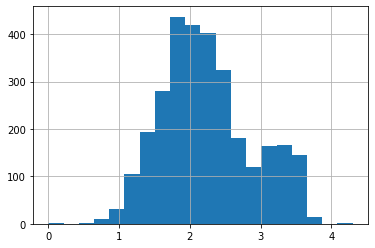

In [ ]:
duration_log = np.log10(meta_train['duration']).replace(-np.inf, 0)
duration_log.hist(bins=20)

In [ ]:
meta_train['ad_blocked'].value_counts()

False    2980
True       20
Name: ad_blocked, dtype: int64

In [ ]:
meta_train['embed'].value_counts()

True     2982
False      18
Name: embed, dtype: int64

In [ ]:
pd.crosstab(meta_train.partner, meta_train.partner_active)

partner_active,False,True
partner,,
False,1194,0
True,1123,683


In [ ]:
# correlation btwn numerical variables
cor_tbl_df = meta_train[['views', 'ratio', 'duration', 'language', 'n_likes', 'n_tags','n_formats', 'dayofweek', 'hour']]
sort_n = cor_tbl_df.corr().sort_values('views', ascending=False).index
cor_tbl_df.corr()[sort_n].iloc[0]

views        1.000000
n_likes      0.288940
language     0.105701
ratio        0.102332
n_tags       0.081795
duration     0.073680
n_formats    0.034488
hour        -0.014262
dayofweek   -0.022092
Name: views, dtype: float64

Use get_dummies() to convert categorical variables into dummy variables.

In [ ]:
embed = pd.get_dummies(meta_train.embed, prefix ='embed')
partner = pd.get_dummies(meta_train.partner, prefix ='partner')
partner_active = pd.get_dummies(meta_train.partner_active, prefix ='partner_a')
language = pd.get_dummies(meta_train['language'], prefix='language')
weekday = pd.get_dummies(meta_train['dayofweek'], prefix='day')
weekday['day_6'] = 0
print(embed)

      embed_False  embed_True
0               0           1
1               0           1
2               0           1
3               0           1
4               0           1
...           ...         ...
2995            0           1
2996            0           1
2997            0           1
2998            0           1
2999            0           1

[3000 rows x 2 columns]


In [ ]:
sin_hour = np.sin(2*np.pi*meta_train['hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*meta_train['hour']/24.0)
cos_hour.name = 'cos_hour'

after transformations, we can join all 6 transformed data columns into on data farme

In [ ]:
# Join all dataframes.
meta_final_df = pd.concat([meta_train[['comp_id', 'views', 'ratio', 'language', 'n_likes', 'duration']].reset_index(drop=True),
                           embed, partner, partner_active, language, weekday, sin_hour, cos_hour], axis=1)
meta_final_df.head()
meta_final_df.shape

(3000, 31)

In [ ]:
# Set the target as well as dependent variables from image data.
y = meta_train['views']
x = image_train.loc[:, image_train.columns != 'comp_id'] #ignore comp_id variable

# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  1107.051212533


In [ ]:
# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Counter({True: 1258, False: 2742})

In [ ]:
# Reconstruct the image dataframe using the index information above.
image_index_df = pd.DataFrame(x[x.columns[(sel_index)]])
image_final_df = pd.concat([image_train[['comp_id']], image_index_df], axis=1)
image_final_df.head()

,comp_id,image_1,image_3,image_4,image_11,image_15,image_17,image_20,image_24,image_26,...,image_3959,image_3960,image_3962,image_3966,image_3968,image_3973,image_3974,image_3977,image_3984,image_3990
0,1,0.484456,-0.149328,0.144475,0.780332,-1.193367,0.359643,0.201758,0.392215,0.049990,...,-0.506946,-0.162883,-1.364837,-0.781976,-3.690247,1.522198,-0.606094,0.658431,-0.604360,0.111028
1,2,0.074533,-0.016286,-0.480964,0.410953,0.797866,-0.103046,-0.820352,-0.237525,-0.127445,...,1.284343,0.019412,0.406546,-0.552040,0.225877,1.708743,-0.204869,-0.510086,0.410483,-0.102448
2,3,-0.396809,-1.723037,0.666147,-0.006978,-1.849174,-0.451063,-0.669081,0.824120,0.288842,...,-0.249109,-0.389832,1.867043,1.650881,2.086596,-1.253300,-0.229919,-0.377193,0.605521,-0.384109
3,4,0.995316,0.387472,-0.684791,-0.356708,0.807046,0.111972,0.294054,5.531464,0.550411,...,1.032519,-0.087203,-1.364425,-0.414214,-2.780271,-0.199446,-0.387944,1.334685,0.869679,0.302376
4,5,-0.611648,-0.572393,0.894287,-0.260793,-0.219198,1.063709,0.717563,1.603678,-0.398335,...,-0.082778,-0.765341,0.282487,-0.020776,2.269820,0.469091,1.325833,-0.016011,0.467325,-0.171552


Merge everything into one data frame

In [ ]:
# Merge all tables based on the column 'comp_id'
final_df = pd.merge(pd.merge(meta_final_df, image_final_df, on = 'comp_id'), 
                    pd.merge(desc_train, title_train, on = 'comp_id'), on = 'comp_id')
#final_df = pd.read_csv('final_train_df.csv')

final_df.shape # (3000, 1389)

(3000, 1389)

In [ ]:
# Test set
p_embed = pd.get_dummies(meta_test.embed, prefix ='embed')
p_partner = pd.get_dummies(meta_test.partner, prefix ='partner')
p_partner_active = pd.get_dummies(meta_test.partner_active, prefix ='partner_a')
p_language = pd.get_dummies(meta_test['language'], prefix='language')
p_language['language_6'] = 0
p_weekday = pd.get_dummies(meta_test['dayofweek'], prefix='day')
p_weekday['day_3'] = 0
p_weekday['day_4'] = 0
p_weekday['day_5'] = 0

## Cyclical encoding 
p_sin_hour = np.sin(2*np.pi*meta_test['hour']/24.0)
p_sin_hour.name = 'sin_hour'
p_cos_hour = np.cos(2*np.pi*meta_test['hour']/24.0)
p_cos_hour.name = 'cos_hour'

# Join all dataframes.
p_meta_final_df = pd.concat([meta_test[['comp_id', 'ratio', 'language', 'n_likes', 'duration']].reset_index(drop=True),
                             p_embed, p_partner, p_partner_active, p_language, p_weekday, p_sin_hour, p_cos_hour], axis=1)
p_meta_final_df.head()

# subset our test image dataframe with index used on training set
p_image_final_df = pd.concat([image_test[['comp_id']], image_index_df], axis=1)

# Merge all test set tables.
p_final_df = pd.merge(pd.merge(p_meta_final_df, p_image_final_df, on = 'comp_id'), 
                    pd.merge(desc_test, title_test, on = 'comp_id'), on = 'comp_id')
#p_final_df = pd.read_csv('final_test_df.csv')
p_final_df.shape

(986, 1388)

train test split

In [ ]:
# Convert dataframe to numpy array.
X = final_df.drop(['comp_id', 'views'], axis=1).to_numpy()
y = final_df.loc[:, 'views'].to_numpy()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 121)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)
#print(X_train)
#print(X)

Training set shape  (2250, 1387)
Test set shape  (750, 1387)


In [ ]:
trlabel = y_train
telabel = y_test

dtrain = xgb.DMatrix(X_train, label=trlabel)
dtest  = xgb.DMatrix(X_test, label=telabel)


setting parameters

In [ ]:
# Set parameters.
param = {'max_depth': 7, 
         'eta': 0.2,
         'objective': 'reg:squarederror',
         'nthread': 5,
         'eval_metric': 'rmse'
        }

evallist = [(dtest, 'eval'), (dtrain, 'train')]

train the model

In [ ]:
# Train the model.
num_round = 70
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:1279.23	train-rmse:1179.16
[1]	eval-rmse:1218.13	train-rmse:1059.67
[2]	eval-rmse:1172.41	train-rmse:978.234
[3]	eval-rmse:1140.65	train-rmse:903.757
[4]	eval-rmse:1124.44	train-rmse:839.028
[5]	eval-rmse:1114.6	train-rmse:790.458
[6]	eval-rmse:1110.07	train-rmse:732.671
[7]	eval-rmse:1108.61	train-rmse:708.463
[8]	eval-rmse:1106.16	train-rmse:665.929
[9]	eval-rmse:1106.55	train-rmse:623.156
[10]	eval-rmse:1108.17	train-rmse:597.593
[11]	eval-rmse:1113.58	train-rmse:551.722
[12]	eval-rmse:1112.89	train-rmse:523.347
[13]	eval-rmse:1114.02	train-rmse:496.569
[14]	eval-rmse:1113.89	train-rmse:474.414
[15]	eval-rmse:1116.72	train-rmse:452.051
[16]	eval-rmse:1117.77	train-rmse:433.12
[17]	eval-rmse:1121.4	train-rmse:409.371
[18]	eval-rmse:1125.53	train-rmse:384.556
[19]	eval-rmse:1126.21	train-rmse:370.517
[20]	eval-rmse:1128.62	train-rmse:360.737
[21]	eval-rmse:1129.8	train-rmse:341.253
[22]	eval-rmse:1131.02	train-rmse:323.179
[23]	eval-rmse:1133.28	train-rmse:302.843
[24]	e

In [ ]:
# Make prediction.
ypred = bst.predict(dtest).round()
ytrainpred = bst.predict(dtrain).round()
# Compute RMSE on test set.
mse_xgboost = mean_squared_error(y_test, ypred)
rmse_xgboost = math.sqrt(mse_xgboost)

print('RMSE with XGBoost', rmse_xgboost)
#xgboost.get_params()
print(ypred)

RMSE with XGBoost 1129.371014916415
[1322.  341. 1937.  789. 1268.  494.  239.  390.  323. 1644.  163.  370.
  500. 1889.  139.   51.  569.  233.  266.  218.  327.  218. 1858.  227.
  489.  220.  119.  477.  396. 1137.  744.  436.  447.   80.  352.  259.
  267.   28.  605.  160.  117. 4574.  109.  442.   -9.  592. 1456.  951.
  317.  655. 1873.  140.  364. 2378.  255.  495.  410.  316.  208.  515.
  464.  933.  617.  177.  269.  267.  236.  126.  371. 1599.  191.  341.
  363.  151.  216. 4402. 2568.   85.  404.  606.  111.   23. 1697. 2422.
  305.  205.  271.  441. 1043.  333.  379.  254.  436. 1141. 1018.  232.
  268.  854.  813.  224.  766.  418.  405.  277. 1005.  330.  560.  268.
   32. 4356.  655. 1217.  322.  464.  510.  148.   70.  322.  908.  535.
 1146.  368.  274. 2824.  389.  530.  374.  230.  194. 1616.  271. 1504.
  429.  412.  197. 1212.  112.  618.  970.  964.  178.  231.  284.   56.
  270.   27.  128.  169.  169. 1172. 1111.  488.  196.  676. 1351. 1352.
 1015.  585.  3